# Analysis of results from Toloka survey

In [78]:
# Imports and installs
!pip3 install python-Levenshtein
!pip3 install seaborn
import pandas as pd
import numpy as np 
import datetime
import json
import Levenshtein
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# To be able to import from other notebook
!pip3 install nbimporter
import nbimporter
from extraction import extract_data

# Remove warning
pd.options.mode.chained_assignment = None

hex1, hex2, hex3, hex4 = '#79ccb3', '#92cad1', '#e9724d', '#868686'
large_fontsize = 35
medium_fontsize = 25
small_fontsize = 15

raw = pd.read_json("data/kym.json")        # meme templates from Know Your Meme
events = pd.read_json("data/events.json")  # memes with timestamps from origin and spread
memes = extract_data(raw, events)

# Q1: Have you used this meme before?
# Q2: Have you seen others use this meme?
# Q3: Do you relate to this meme?

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

### Select relevant columns and clean data

In [20]:
results = pd.read_csv("data/toloka_results.tsv", sep="\t")
results = results.drop(columns=['INPUT:image', 'OUTPUT:captcha', 'OUTPUT:text_review_mode', 'GOLDEN:q1', 'GOLDEN:q2', 'GOLDEN:q3', 'GOLDEN:result', 'GOLDEN:captcha', 'GOLDEN:reaction', 'GOLDEN:snowclone', 'GOLDEN:exploitable', 'GOLDEN:text_review_mode', 'HINT:text', 'HINT:default_language', 'ASSIGNMENT:link', 'ASSIGNMENT:task_id', 'ASSIGNMENT:assignment_id', 'ASSIGNMENT:worker_id', 'ASSIGNMENT:status'])
results['OUTPUT:result'] = results['OUTPUT:result'].apply(lambda x: json.loads(x))

# Convert multiple-choice answers to boolean
results['OUTPUT:q1'] = results['OUTPUT:q1'].map({'1y': True, '1n': False})
results['OUTPUT:q2'] = results['OUTPUT:q2'].map({'2y': True, '2n': False})
results['OUTPUT:q3'] = results['OUTPUT:q3'].map({'3y': True, '3n': False})

# Calculate time taken per assignment
results['ASSIGNMENT:submitted'] = pd.to_datetime(results['ASSIGNMENT:submitted'])
results['ASSIGNMENT:started'] = pd.to_datetime(results['ASSIGNMENT:started'])
results['minutes_taken'] = results['ASSIGNMENT:submitted'] - results['ASSIGNMENT:started']
results['minutes_taken'] = results['minutes_taken'].apply(lambda x: round(x.total_seconds() / 60, 2))
results = results.drop(columns=['ASSIGNMENT:started', 'ASSIGNMENT:submitted'])

results.head()

,INPUT:input,INPUT:memelink,OUTPUT:q1,OUTPUT:q2,OUTPUT:q3,OUTPUT:result,OUTPUT:reaction,OUTPUT:snowclone,OUTPUT:exploitable,minutes_taken
0,Autistic Screeching is an exploitable comic se...,https://knowyourmeme.com/memes/autistic-screec...,False,False,False,"{'Title': ['Autistic Screeching', '""autistic s...",False,True,False,8.59
1,"No Items, Fox Only, Final Destination is a cat...",https://knowyourmeme.com/memes/no-items-fox-on...,False,False,False,"{'Title': ['No Items, Fox Only, Final Destinat...",True,False,False,5.60
2,Lie Down / Try Not to Cry / Cry a Lot refers a...,https://knowyourmeme.com/memes/lie-down-try-no...,False,False,False,"{'Title': ['Lie Down', 'Try Not to Cry', 'Cry ...",True,False,False,2.71
3,Autistic Screeching is an exploitable comic se...,https://knowyourmeme.com/memes/autistic-screec...,False,False,False,"{'Title': ['Autistic Screeching'], 'Meaning': ...",True,False,False,6.74
4,Y'all Consider This A Date? refers to a series...,https://knowyourmeme.com/memes/yall-consider-t...,False,False,False,"{'Title': ['Y'all Consider This A Date?'], 'Me...",False,False,True,9.53


## Time taken for annotation

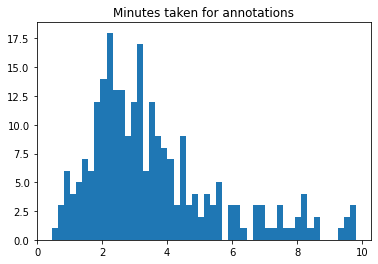

In [14]:
# Plot time taken for annotations (in minutes)
plt.hist(results['minutes_taken'], bins = 50)
# plt.bar(results['minutes_taken'], bins = len(results))
plt.title("Minutes taken for annotations")
plt.show()

## Analysis of multiple-choice answers

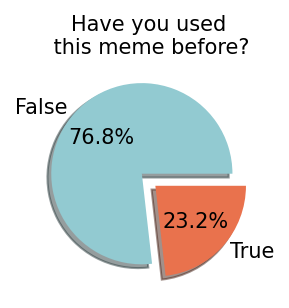

In [86]:
# Add year as separate column
from collections import Counter
plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 150

plot_data = Counter(results['OUTPUT:q1'])

plt.figure(figsize=(2, 2), dpi=150)
plt.pie(x = plot_data.values(), labels = plot_data.keys(), colors=[hex2, hex3], autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1))
# plt.ylabel('Total number', fontsize=medium_fontsize)
# plt.xlabel('Year', fontsize=medium_fontsize)
plt.title("Have you used\n this meme before?", fontsize=large_fontsize - 25)
# plt.xticks(ticks=[0,1], labels=["False", "True"], fontsize=small_fontsize)
# plt.yticks(fontsize=small_fontsize)
# plt.xlim([-1,len(plot_data.keys())])
# plt.set_size_inches(8, 6)
# plt.savefig('graphs/q1.png', bbox_inches='tight')
plt.show()

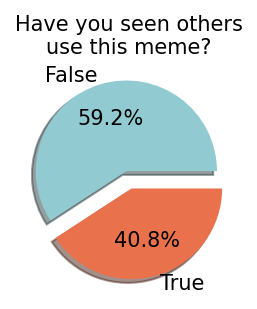

In [85]:
plot_data = Counter(results['OUTPUT:q2'])

plt.figure(figsize=(2, 2), dpi=150)
plt.pie(x = plot_data.values(), labels = plot_data.keys(), colors=[hex2, hex3], autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1))
# plt.ylabel('Total number', fontsize=medium_fontsize)
# plt.xlabel('Year', fontsize=medium_fontsize)
plt.title("Have you seen others\nuse this meme?", fontsize=large_fontsize - 25)
# plt.xticks(ticks=[0,1], labels=["False", "True"], fontsize=small_fontsize)
# plt.yticks(fontsize=small_fontsize)
# plt.xlim([-1,len(plot_data.keys())])
# plt.savefig('graphs/q2.png', bbox_inches='tight')
plt.show()

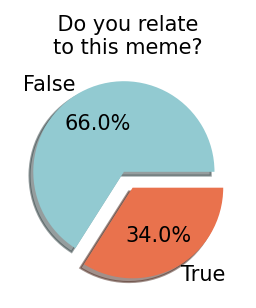

In [84]:
plot_data = Counter(results['OUTPUT:q3'])

plt.figure(figsize=(2, 2), dpi=150)
plt.pie(x = plot_data.values(), labels = plot_data.keys(), colors=[hex2, hex3], autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1))
# plt.ylabel('Total number', fontsize=medium_fontsize)
# plt.xlabel('Year', fontsize=medium_fontsize)
plt.title("    Do you relate    \n     to this meme?     ", fontsize=large_fontsize - 25)
# plt.xticks(ticks=[0,1], labels=["False", "True"], fontsize=small_fontsize)
# plt.yticks(fontsize=small_fontsize)
# plt.xlim([-1,len(plot_data.keys())])
# plt.savefig('graphs/q3.png', bbox_inches='tight')
plt.show()

In [14]:
# Agreement between questions
agreement = results['OUTPUT:q2'] == results['OUTPUT:q3']
agreement = [1 if a == b and a == True else 0 for a,b in zip(results['OUTPUT:q2'], results['OUTPUT:q3'])]
print(sum(agreement) / len(agreement))

0.216


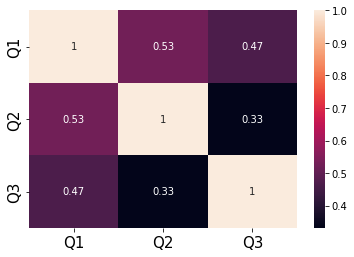

In [52]:
# Correlation between Q1, Q2 and Q3
questions = results[['OUTPUT:q1', 'OUTPUT:q2', 'OUTPUT:q3']]
questions['OUTPUT:q1'] = questions['OUTPUT:q1'].map({True: 1, False: 0})
questions['OUTPUT:q2'] = questions['OUTPUT:q2'].map({True: 1, False: 0})
questions['OUTPUT:q3'] = questions['OUTPUT:q3'].map({True: 1, False: 0})

questions.columns = ['Q1', 'Q2', 'Q3']
corr = questions.corr()
#print(corr)
sn.heatmap(corr, annot=True)
plt.xticks(fontsize=small_fontsize)
plt.yticks(fontsize=small_fontsize)
plt.show()

In [93]:
# TODO check agreement between every meme's type (there are 5 annotations, what percentage of them match? – not sure how to measure)
# TODO you can check whether the type they selected matches the type(s) that we have in the dataset as "GROUND TRUTH"! this is much easier
types = results[['INPUT:memelink', 'OUTPUT:reaction', 'OUTPUT:snowclone', 'OUTPUT:exploitable']]
types.rename(columns = {'INPUT:memelink':'url'}, inplace = True)
types = pd.merge(types, memes, on="url", how="left")
types = types[['url', 'type', 'OUTPUT:reaction', 'OUTPUT:snowclone', 'OUTPUT:exploitable']]

typematch = []
for target, r, s, e in zip(types['type'], types['OUTPUT:reaction'], types['OUTPUT:snowclone'], types['OUTPUT:exploitable']):
    output = set()
    if r == True:
        output.add("reaction")
    if s == True:
        output.add("snowclone")
    if e == True:
        output.add("exploitable")
    if len(output.intersection(set(target))) > 0:
        typematch.append(1)
    else:
        typematch.append(0)
    
print("Percentage of annotations that got the type right:", sum(typematch) / len(typematch))

Percentage of annotations that got the type right: 0.6


## Compare highlight similarity: MEANING

In [149]:
annotations = {key:[] for key in set(results['INPUT:memelink'])}
for url, highlights in zip(results['INPUT:memelink'], results['OUTPUT:result']):
    annotations[url].append(highlights)

# Number of annotations for Meaning
num_annotations = {key:[] for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    num_annotations[key] = [len(x['Meaning']) if 'Meaning' in x.keys() else 0 for x in val]

# Rank the annotation similarity by standard deviation of NUMBER of annotations
std_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in num_annotations.items():
    std_annotations[key] = np.std(val)
std_annotations = dict(sorted(std_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of NUMBER of annotations (meaning):\n", std_annotations)

Standard deviation of NUMBER of annotations (meaning):
 {'https://knowyourmeme.com/memes/ideal-gf': 0.0, 'https://knowyourmeme.com/memes/ew-i-stepped-in-shit': 0.0, 'https://knowyourmeme.com/memes/the-deathbulge-party-saga': 0.0, 'https://knowyourmeme.com/memes/pennywise-the-clown': 0.0, 'https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is': 0.0, 'https://knowyourmeme.com/memes/repost-if-x': 0.0, 'https://knowyourmeme.com/memes/bitches-love-smiley-faces': 0.0, 'https://knowyourmeme.com/memes/misinformationalized-you-hear-about-video-games': 0.0, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 0.0, 'https://knowyourmeme.com/memes/modern-society-parodies': 0.0, 'https://knowyourmeme.com/memes/thats-where-youre-wrong-kiddo': 0.0, 'https://knowyourmeme.com/memes/oh-no-its-retarded': 0.0, 'https://knowyourmeme.com/memes/is-this-a-pigeon': 0.0, 'https://knowyourmeme.com/memes/your-next-line-is': 0.4, 'https://knowyourmeme.com/memes/does-he-bite': 0.4, '

### Rank the annotation similarity by standard deviation of AVERAGE LENGTH of annotations

In [148]:
length_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    avg_lengths = []
    for ann in val:
        avg = []
        if 'Meaning' in ann.keys():
            for highlight in ann['Meaning']:
                avg.append(len(highlight))
            avg_lengths.append(sum(avg) / len(avg))
        else:
            avg_lengths.append(0)
    length_annotations[key] = np.std(avg_lengths)
    
length_annotations = dict(sorted(length_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of AVERAGE LENGTH of annotations (meaning):\n", length_annotations)

Standard deviation of AVERAGE LENGTH of annotations (meaning):
 {'https://knowyourmeme.com/memes/modern-society-parodies': 4.758150901348127, 'https://knowyourmeme.com/memes/oh-you-love-x-name-every-y': 5.427706698044765, 'https://knowyourmeme.com/memes/pennywise-the-clown': 5.782732917920384, 'https://knowyourmeme.com/memes/i-was-only-pretending-to-be-retarded': 12.077251342917394, 'https://knowyourmeme.com/memes/your-mother-and-i-will-always-love-you': 17.26962651593832, 'https://knowyourmeme.com/memes/ideal-gf': 18.24938355123263, 'https://knowyourmeme.com/memes/no-items-fox-only-final-destination': 18.30409790183608, 'https://knowyourmeme.com/memes/i-am-altering-the-deal': 18.993098161642237, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 21.30352083576797, 'https://knowyourmeme.com/memes/how-to-talk-to-short-people': 21.509067855209345, 'https://knowyourmeme.com/memes/oh-no-its-retarded': 21.73844520659194, 'https://knowyourmeme.com/memes/cant-argue-with-that-technicall

### Rank the annotation similarity by Levenshtein distance of annotations

In [177]:
highlights = {key:[] for key in set(results['INPUT:memelink'])}
distances = {key:{} for key in set(results['INPUT:memelink'])}

# Make dictionary of highlights with IDs
for key, val in annotations.items():
    ID = 0
    anns = []
    for ann in val:
        ID += 1
        if 'Meaning' in ann.keys():
            for a in ann['Meaning']:
                anns.append((ID, a))
        else:
            anns.append((ID, "")) # Missing annotations
    highlights[key] = anns

# Calculate distances
for key, val in highlights.items():
    lev = {}
    for i in range(len(val) - 1):
        for j in range(i + 1, len(val)):
            ann1 = val[i]
            ann2 = val[j]
            if ann1[0] != ann2[0]:
                new_key = "A" + str(ann1[0]) + "-A" + str(ann2[0])
                if new_key in lev.keys():
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key].append(-1)
                    else:
                        lev[new_key].append(Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-")))
                else:
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key] = [-1]
                    else:
                        lev[new_key] = [Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))]
    distances[key] = lev
    
# Create flat list with all distances, find max for normalization
hist_data = [x for val in distances.values() for x in val.values()]
hist_data = [x for sublist in hist_data for x in sublist if x != -1]
max_dist = max(hist_data)
       
matrices = {}       
col_names = ['A1', 'A2', 'A3', 'A4', 'A5']
for key, value in distances.items():
    columns = {key:[] for key in col_names}
    c = 0
    for k, v in value.items():
        l = [x for x in v if x != -1]
        dist =  min(l) if len(l) > 0 else np.nan
        columns[k[:2]].append(dist / max_dist)  # normalize to [0,1]

    # Add np.nan to make matrix complete
    for k in columns.keys():
        for i in range(5 - len(columns[k])):
            columns[k].insert(0, np.nan)
          
    df = pd.DataFrame(columns, index = col_names)    
    
    # Mirror bottom values to top
    for i in range(1,6):
        label = 'A' + str(i)
        col = df[label]
        row = df.loc[label]
        new_row = []
        for c, r in zip(col, row):
            if c != np.nan:
                new_row.append(c)
            else:
                new_row.append(r)
        df.loc[label] = new_row
    
    # Change diagonal values to 0
    np.fill_diagonal(df.values, 0)
    
    # Apply similarity threshold
    df = df.applymap(lambda x: 1 if x < 0.1 else 0)
    
    # Add new row with sum
    df.loc["Total"] = df.sum()
    
    matrices[key] = df

#print(matrices.keys())
#matrices['https://knowyourmeme.com/memes/ideal-gf'].head(6)
matrices['https://knowyourmeme.com/memes/top-gun-hat'].head(6)

,A1,A2,A3,A4,A5
A1,1,1,1,0,0
A2,1,1,1,0,0
A3,1,1,1,0,0
A4,0,0,0,1,0
A5,0,0,0,0,1
Total,3,3,3,1,1


[31, 139, 142, 120, 108, 111, 89, 3, 29, 7, 46, 27, 40, 39, 20, 33, 19, 6, 25, 89, 86, 246, 306, 280, 97, 169, 217, 191, 169, 220, 194, 102, 88, 292, 42, 204, 149, 98, 146, 242, 191, 55, 109, 40, 54, 15, 69, 136, 76, 58, 99, 191, 93, 0, 89, 91, 89, 0, 42, 89, 55, 61, 81, 91, 0, 42, 61, 91, 84, 34, 61, 57, 3, 55, 0, 55, 13, 56, 195, 187, 3, 16, 198, 13, 195, 208, 18, 124, 18, 106, 0, 106, 3, 46, 24, 49, 27, 22, 8, 5, 66, 8, 3, 58, 0, 61, 3, 58, 128, 58, 60, 58, 127, 128, 127, 2, 0, 2, 7, 8, 0, 7, 15, 7, 0, 8, 15, 7, 28, 34, 95, 28, 31, 51, 104, 61, 0, 56, 57, 3, 40, 57, 104, 64, 80, 40, 56, 0, 32, 64, 0, 0, 62, 32, 64, 0, 0, 62, 32, 64, 32, 55, 64, 2, 0, 62, 95, 88, 92, 24, 152, 108, 245, 144, 244, 176, 137, 36, 136, 113, 108, 89, 91, 0, 84, 76, 133, 85, 131, 28, 76, 85, 23, 85, 76, 100, 85, 103, 23, 131, 28, 23, 103, 23, 132, 5, 168, 132, 78, 5, 83, 0, 115, 30, 110, 20, 115, 30, 108, 10, 50, 0, 40, 50, 10, 40, 68, 44, 33, 3, 24, 35, 71, 11, 47, 36, 102, 70, 105, 119, 112, 0, 107, 87, 2

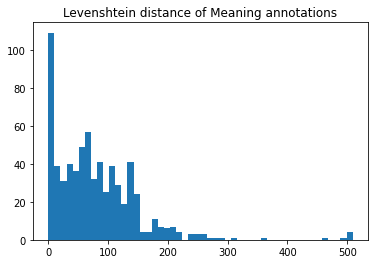

In [146]:
# Plot levenshtein distance histogram
plt.hist(hist_data, bins = 50)
plt.title("Levenshtein distance of Meaning annotations")
plt.show() 

## Compare highlight similarity: TITLE

In [38]:
annotations = {key:[] for key in set(results['INPUT:memelink'])}
for url, highlights in zip(results['INPUT:memelink'], results['OUTPUT:result']):
    annotations[url].append(highlights)

# Number of annotations for Title
num_annotations = {key:[] for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    num_annotations[key] = [len(x['Title']) if 'Title' in x.keys() else 0 for x in val]

# Rank the annotation similarity by standard deviation of NUMBER of annotations
std_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in num_annotations.items():
    std_annotations[key] = np.std(val)
std_annotations = dict(sorted(std_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of NUMBER of annotations (title):\n", std_annotations)

Standard deviation of NUMBER of annotations (title):
 {'https://knowyourmeme.com/memes/art-gallery-puking': 0.0, 'https://knowyourmeme.com/memes/ideal-gf': 0.0, 'https://knowyourmeme.com/memes/does-he-bite': 0.0, 'https://knowyourmeme.com/memes/darth-vaders-i-find-your-lack-of-faith-disturbing': 0.0, 'https://knowyourmeme.com/memes/dashing-black-man-holding-dangerously-large-dorito-chip': 0.0, 'https://knowyourmeme.com/memes/pretty-cool-guy': 0.0, 'https://knowyourmeme.com/memes/the-deathbulge-party-saga': 0.0, 'https://knowyourmeme.com/memes/pennywise-the-clown': 0.0, 'https://knowyourmeme.com/memes/oh-you-love-x-name-every-y': 0.0, 'https://knowyourmeme.com/memes/swear-jar': 0.0, 'https://knowyourmeme.com/memes/cant-argue-with-that-technically-not-wrong': 0.0, 'https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is': 0.0, 'https://knowyourmeme.com/memes/running-dad': 0.0, 'https://knowyourmeme.com/memes/i-see-dead-people': 0.0, 'https://knowyourmeme.com/meme

In [39]:
# Rank the annotation similarity by standard deviation of AVERAGE LENGTH of annotations
length_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    avg_lengths = []
    for ann in val:
        avg = []
        if 'Title' in ann.keys():
            for highlight in ann['Title']:
                avg.append(len(highlight))
            avg_lengths.append(sum(avg) / len(avg))
        else:
            avg_lengths.append(0)
    length_annotations[key] = np.std(avg_lengths)
    
length_annotations = dict(sorted(length_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of AVERAGE LENGTH of annotations (title):\n", length_annotations)

Standard deviation of AVERAGE LENGTH of annotations (title):
 {'https://knowyourmeme.com/memes/ideal-gf': 0.0, 'https://knowyourmeme.com/memes/darth-vaders-i-find-your-lack-of-faith-disturbing': 0.0, 'https://knowyourmeme.com/memes/pretty-cool-guy': 0.0, 'https://knowyourmeme.com/memes/the-deathbulge-party-saga': 0.0, 'https://knowyourmeme.com/memes/pennywise-the-clown': 0.0, 'https://knowyourmeme.com/memes/swear-jar': 0.0, 'https://knowyourmeme.com/memes/cant-argue-with-that-technically-not-wrong': 0.0, 'https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is': 0.0, 'https://knowyourmeme.com/memes/running-dad': 0.0, 'https://knowyourmeme.com/memes/your-mother-and-i-will-always-love-you': 0.0, 'https://knowyourmeme.com/memes/what-are-you-watching': 0.0, 'https://knowyourmeme.com/memes/i-was-only-pretending-to-be-retarded': 0.0, 'https://knowyourmeme.com/memes/4-panel-cringe': 0.0, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 0.0, 'https://knowyourm

In [67]:
# Rank the annotation similarity by Levenshtein distance of annotations
highlights = {key:[] for key in set(results['INPUT:memelink'])}
distances = {key:{} for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    ID = 0
    anns = []
    for ann in val:
        ID += 1
        if 'Title' in ann.keys():
            for a in ann['Title']:
                anns.append((ID, a))
        else:
            anns.append((ID, "")) # Missing annotations
    highlights[key] = anns


for key, val in highlights.items():
    lev = {}
    for i in range(len(val) - 1):
        for j in range(i + 1, len(val)):
            ann1 = val[i]
            ann2 = val[j]
            if ann1[0] != ann2[0]:
                new_key = "A" + str(ann1[0]) + "-A" + str(ann2[0])
                if new_key in lev.keys():
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key].append(-1)
                    else:
                        lev[new_key].append(Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-")))
                else:
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key] = [-1]
                    else:
                        lev[new_key] = [Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))]
    distances[key] = lev
            

col_names = ['url', 'A1-A2', 'A1-A3', 'A1-A4', 'A1-A5', 'A2-A3', 'A2-A4', 'A2-A5', 'A3-A4', 'A3-A5', 'A4-A5']
columns = {key:[] for key in col_names}

for key, value in distances.items():
    columns['url'].append(key)
    for k, v in value.items():
        columns[k].append([x for x in v if x != -1])  # Remove missing values

df = pd.DataFrame(columns)
df.head(10)

,url,A1-A2,A1-A3,A1-A4,A1-A5,A2-A3,A2-A4,A2-A5,A3-A4,A3-A5,A4-A5
0,https://knowyourmeme.com/memes/art-gallery-puking,[253],[253],[253],[253],[0],[0],[0],[0],[0],[0]
1,https://knowyourmeme.com/memes/ideal-gf,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2,https://knowyourmeme.com/memes/your-next-line-is,"[74, 63, 64]","[70, 63, 64]",[70],"[70, 63, 64, 71]","[4, 11, 18, 8, 0, 18, 19, 18, 0]","[4, 8, 19]","[4, 11, 18, 3, 8, 0, 18, 9, 19, 18, 0, 20]","[0, 8, 19]","[0, 8, 19, 1, 8, 0, 18, 9, 19, 18, 0, 20]","[0, 8, 19, 1]"
3,https://knowyourmeme.com/memes/disappointed-bl...,[0],"[17, 19]",[0],[0],"[17, 19]",[0],[0],"[17, 19]","[17, 19]",[0]
4,https://knowyourmeme.com/memes/at-first-i-was-...,[39],[0],[],[0],[39],[],[39],[],[0],[]
5,https://knowyourmeme.com/memes/does-he-bite,[0],[204],[0],[12],[204],[0],[12],[204],[215],[12]
6,https://knowyourmeme.com/memes/desk-flip,"[0, 5, 5, 0, 0, 5]","[0, 5, 5, 0, 0, 5]","[0, 5, 0, 5, 0, 5, 0, 5, 0]","[0, 5, 0]","[0, 5, 5, 0]","[0, 5, 0, 5, 0, 5]","[0, 5]","[0, 5, 0, 5, 0, 5]","[0, 5]","[0, 5, 0]"
7,https://knowyourmeme.com/memes/darth-vaders-i-...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
8,https://knowyourmeme.com/memes/dashing-black-m...,[0],[0],[0],[44],[0],[0],[44],[0],[44],[44]
9,https://knowyourmeme.com/memes/pretty-cool-guy,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]


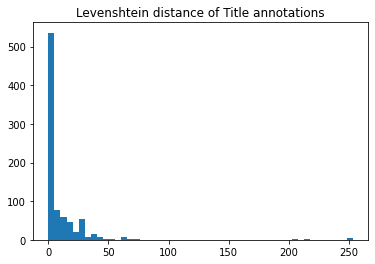

In [73]:
# Plot levenshtein distance histogram
hist_data = [x for val in distances.values() for x in val.values()]
hist_data = [x for sublist in hist_data for x in sublist if x != -1]
plt.hist(hist_data, bins = 50)
plt.title("Levenshtein distance of Title annotations")
plt.show() 